## Our goal

* Predict various protein structures in cellular images
* there are 28 different target proteins
* multiple proteins can be present in one image (multilabel classification)

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf


import os
print(os.listdir("."))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', '.ipynb_checkpoints', 'kernel.ipynb', 'sample_submission.csv']


In [5]:
train_labels = pd.read_csv("train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


How many samples do we have?

In [6]:
train_labels.shape[0]

31072

## Helper code

In [7]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [36]:
label_names.get(0)

'Nucleoplasm'

## Which proteins occur most often in images?

In [8]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [9]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate filaments,Actin filaments,Focal adhesion sites,Microtubules,Microtubule ends,Cytokinetic bridge,Mitotic spindle,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
train_labels.at[1, "Nucleoplasm"]

1

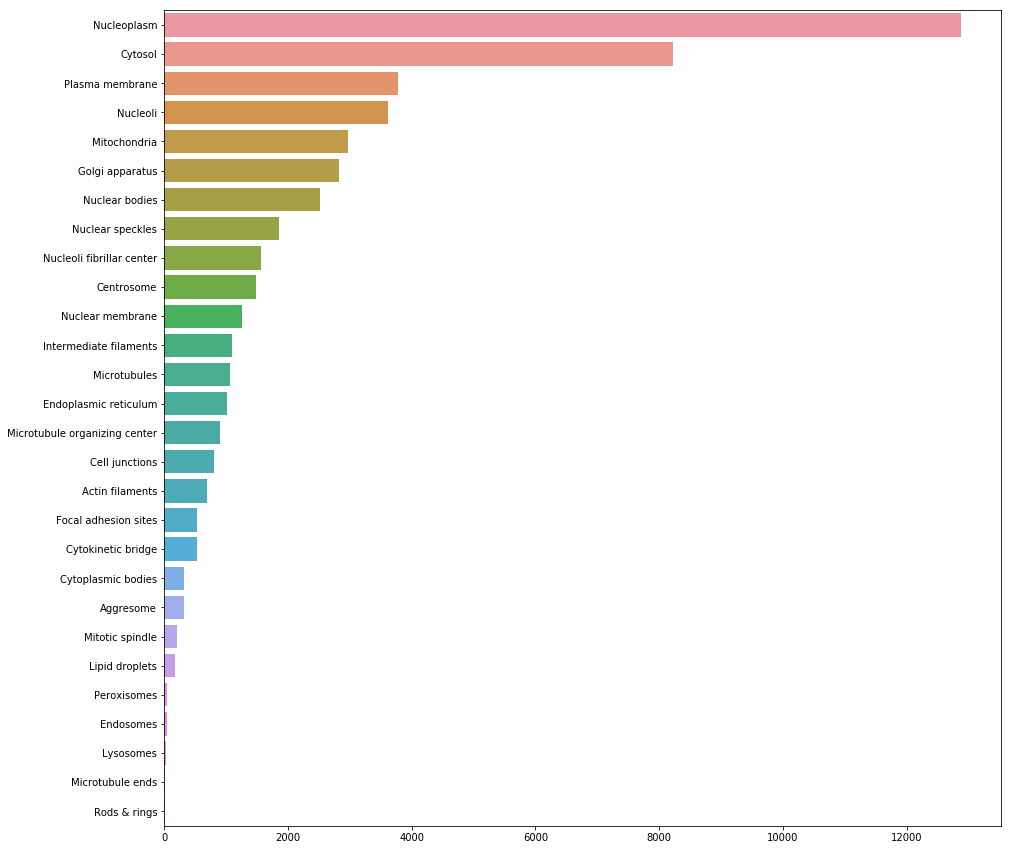

In [11]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

### Take-Away

* We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus. 
* In contrast small components like the lipid droplets, peroxisomes, endosomes, lysosomes, microtubule ends, rods and rings are very seldom in our train data. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variabilities and as our model probably will be confused during ins learning process by the major classes. Due to this confusion we will make less accurate predictions on the minor classes.
* Consequently accuracy is not the right score here to measure your performance and validation strategy should be very fine. 

## How many targets are most common?

Text(0,0.5,'% of data')

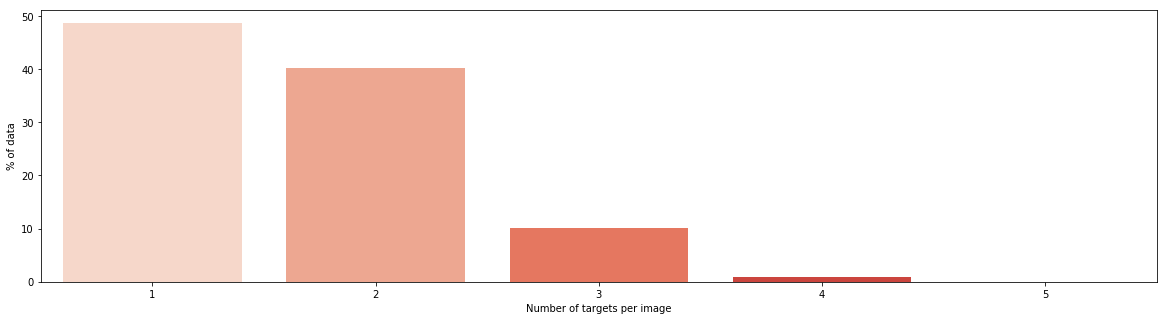

In [12]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

In [13]:
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate filaments,Actin filaments,Focal adhesion sites,Microtubules,Microtubule ends,Cytokinetic bridge,Mitotic spindle,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings,number_of_targets
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


### Take-away

* Most train images only have 1 or two target labels.
* More than 3 targets are very seldom!

## Which targets are correlated?

Let's see if we find some correlations between our targets. This way we may already see that some proteins often come together.

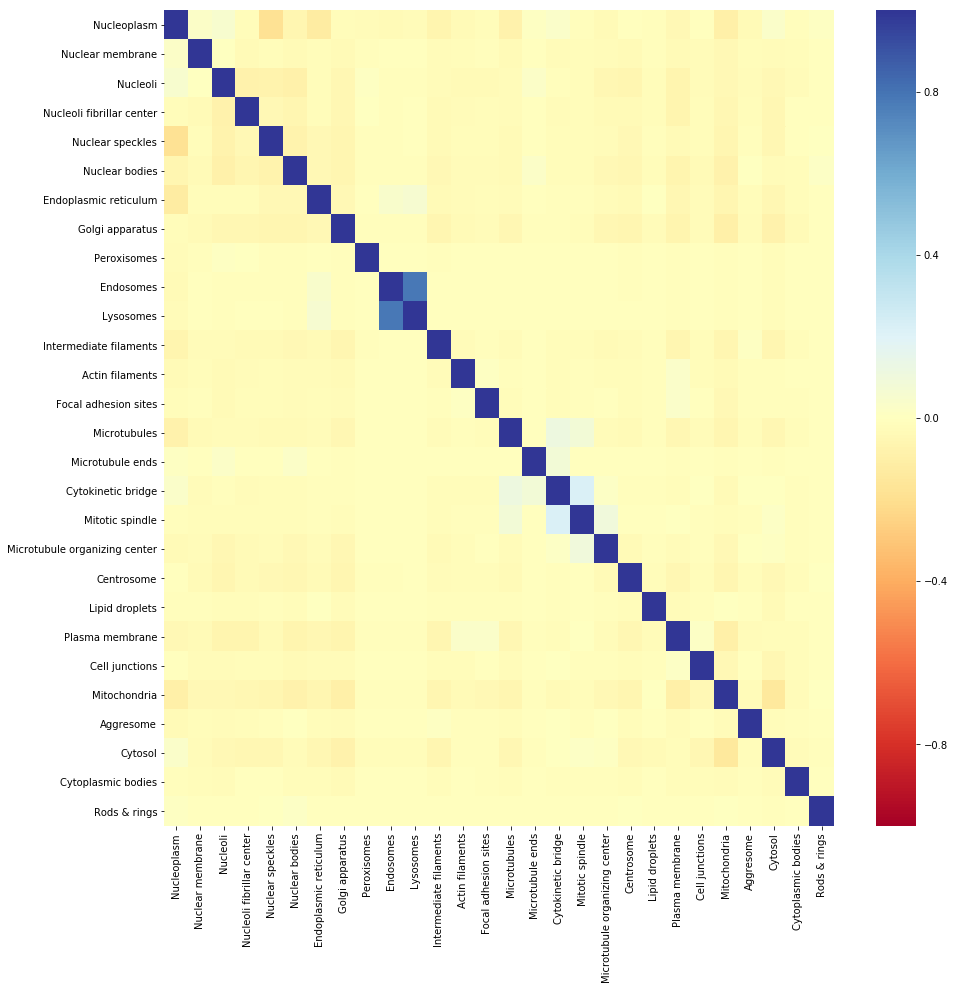

In [14]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels.drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

### Take-away

* We can see that many targets only have very slight correlations. 
* In contrast, endosomes and lysosomes often occur together and sometimes seem to be located at the endoplasmatic reticulum. 
* In addition we find that the mitotic spindle often comes together with the cytokinetic bridge. This makes sense as both are participants for cellular division. And in this process microtubules and thier ends are active and participate as well. Consequently we find a positive correlation between these targets.

## How are special and seldom targets grouped?

### Lysosomes and endosomes

Let's start with these high correlated features!

In [15]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

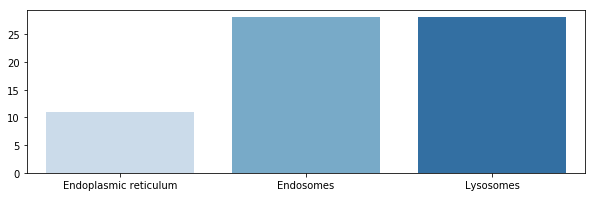

In [16]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")

### Rods and rings

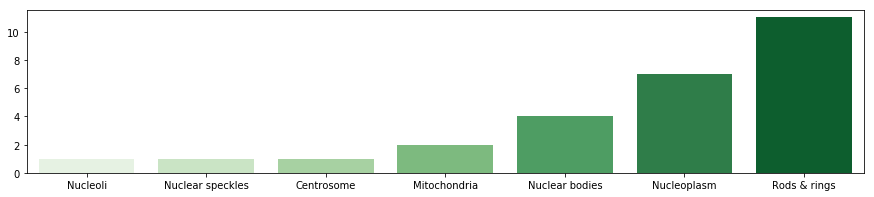

In [17]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")

### Peroxisomes

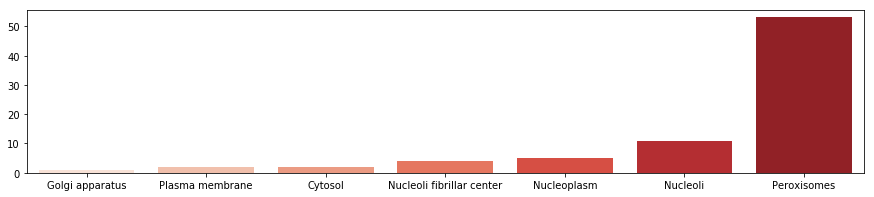

In [18]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

### Microtubule ends

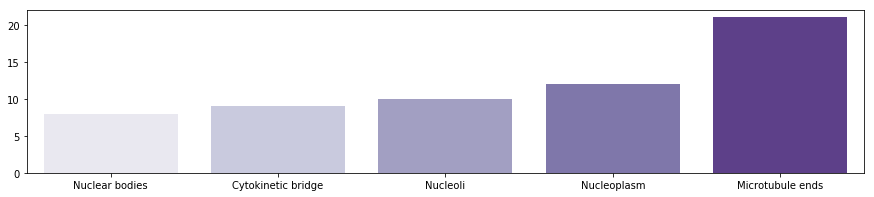

In [19]:
tubeends_counts = find_counts("Microtubule ends", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

### Nuclear speckles

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

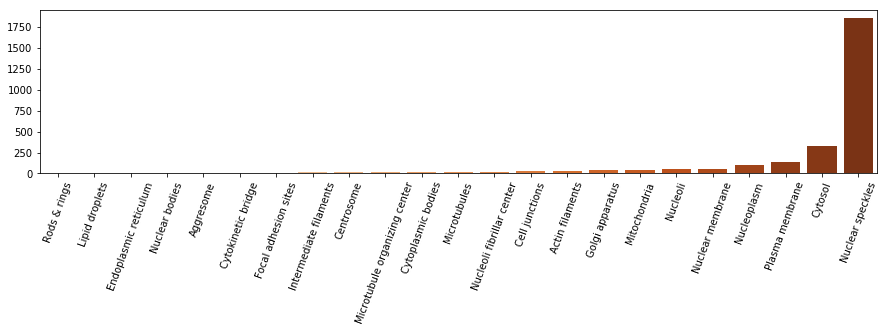

In [20]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")

### Take-away

* We can see that even with very seldom targets we find some kind of grouping with other targets that reveal where the protein structure seems to be located. 
* For example, we can see that rods and rings have something to do with the nucleus whereas peroxisomes may be located in the nucleus as well as in the cytosol.
* Perhaps this patterns might help to build a more robust model!  

## How do the images look like?



### Peek into the directory

Before we start loading images, let's have a look into the train directory to get an impression of what we can find there:

In [21]:
from os import listdir

files = listdir("train")
for n in range(10):
    print(files[n])

27e40a9e-bba0-11e8-b2b9-ac1f6b6435d0_blue.png
d62ecaac-bb9c-11e8-b2b9-ac1f6b6435d0_red.png
7e535876-bbaf-11e8-b2ba-ac1f6b6435d0_green.png
7ea94422-bbb7-11e8-b2ba-ac1f6b6435d0_blue.png
9b00c9c4-bbad-11e8-b2ba-ac1f6b6435d0_red.png
9c5d3b22-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
f55e17de-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
f1b04ab4-bbb8-11e8-b2ba-ac1f6b6435d0_blue.png
c57b55f6-bbbd-11e8-b2ba-ac1f6b6435d0_green.png
6b23a7c6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png


In [22]:
for n in range(20):
    print(files[n])


27e40a9e-bba0-11e8-b2b9-ac1f6b6435d0_blue.png
d62ecaac-bb9c-11e8-b2b9-ac1f6b6435d0_red.png
7e535876-bbaf-11e8-b2ba-ac1f6b6435d0_green.png
7ea94422-bbb7-11e8-b2ba-ac1f6b6435d0_blue.png
9b00c9c4-bbad-11e8-b2ba-ac1f6b6435d0_red.png
9c5d3b22-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
f55e17de-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
f1b04ab4-bbb8-11e8-b2ba-ac1f6b6435d0_blue.png
c57b55f6-bbbd-11e8-b2ba-ac1f6b6435d0_green.png
6b23a7c6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png
a937116c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
59246d3e-bbc2-11e8-b2bb-ac1f6b6435d0_green.png
d0c84962-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
cd9fa018-bbac-11e8-b2ba-ac1f6b6435d0_blue.png
eca02a3c-bbb1-11e8-b2ba-ac1f6b6435d0_blue.png
a90db1aa-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
e8cc5328-bbb5-11e8-b2ba-ac1f6b6435d0_red.png
13b011fe-bb9a-11e8-b2b9-ac1f6b6435d0_green.png
1c2dc922-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
f34b5776-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


Ah, ok, great! It seems that for one image id, there are different color channels present. Looking into the data description of this competition we can find that:

* Each image is actually splitted into 4 different image files. 
* These 4 files correspond to 4 different filter:
    * a **green** filter for the **target protein structure** of interest
    * **blue** landmark filter for the **nucleus**
    * **red** landmark filter for **microtubules**
    * **yellow** landmark filter for the **endoplasmatic reticulum**
* Each image is of size 512 x 512

Let's check if the number of files divided by 4 yields the number of target samples:

In [23]:
len(files) / 4 == train_labels.shape[0]

False

## How do images of specific targets look like?

While looking at examples, we can build an batch loader (work in progress):

In [29]:
train_path = "train/"

In [25]:
def check_subset(targets, target_list):
    return np.where(set(target_list).issuperset(set(targets)), 1, 0)

def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def load_target_group(basepath, target_list, batch_size):
    target_list = [reverse_train_labels[key] for key in target_list]
    train_labels["check_col"] = train_labels.Target.apply(
        lambda l: check_subset(l, target_list)
    )
    images_identifier = train_labels[train_labels.check_col==1].Id.values
    train_labels.drop("check_col", axis=1, inplace=True)
    subgroup = images_identifier[0:batch_size]j
    images = np.zeros(shape=(batch_size, 4, 512, 512))
    for n in range(batch_size):
        images[n,:,:,:] = load_image(basepath, subgroup[n])
    return images, subgroup

In [26]:
def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[2].imshow(image[2], cmap="Blues")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

Let's try to visualize specific target groups. **In this example we will see images that contain the protein structures lysosomes or endosomes**. Set target values of your choice and the target group load method will collect all images that are subset of your choice:

In [40]:
your_choice = [label_names.get(1)]

In [41]:
your_choice

['Nuclear membrane']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f73a3248f98>,
      dtype=object)

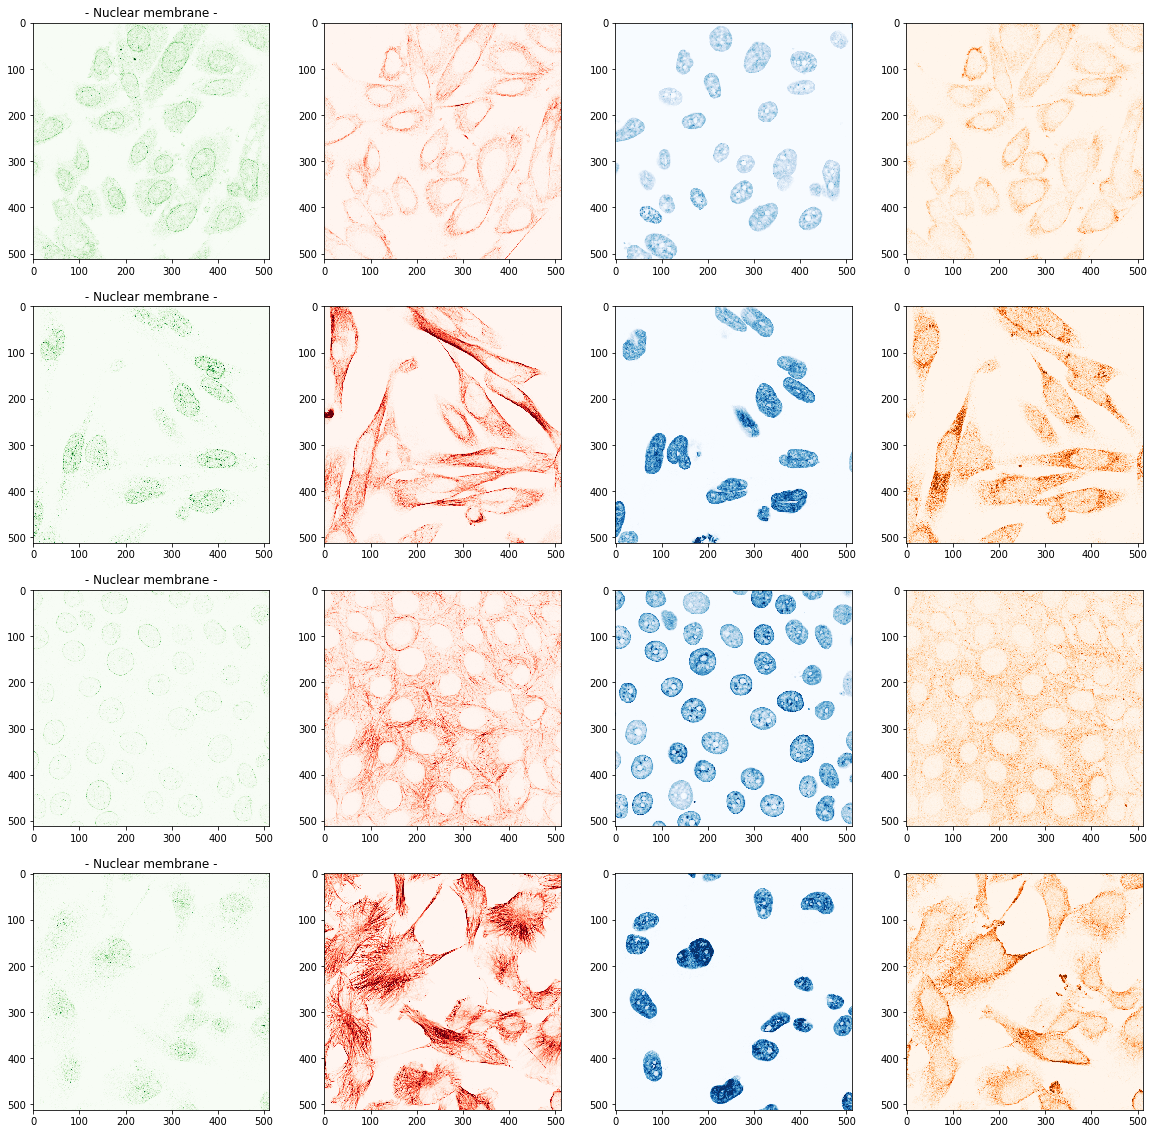

In [42]:
images, file_ids = load_target_group(train_path, your_choice, 5)

fig, ax = plt.subplots(4,4,figsize=(20,20))
make_image_row(images[0,:,:,:], ax[0,:], make_title(file_ids[0]))
make_image_row(images[1,:,:,:], ax[1,:], make_title(file_ids[1]))
make_image_row(images[2,:,:,:], ax[2,:], make_title(file_ids[2]))
make_image_row(images[3,:,:,:], ax[3,:], make_title(file_ids[3]))